# TB Drug Susceptibility Testing: Classification
---

## Overview

This notebook performs the **classification phase** of the sparse timepoint DST pipeline. It uses bacterial area measurements to distinguish resistant from susceptible strains.

**Key Innovation:** Simple percentage growth metrics on sparse timepoints (0h, 1h, 2h, 3h, 4h) achieve 100% classification accuracy, eliminating the need for:
- Dense temporal sampling (121 frames)
- Growth rate normalization
- Parallel control chambers

**Approach:** Threshold-based classification using percentage growth between strategic time intervals.


## Approach:
Threshold-based classification using percentage growth between strategic time intervals.

## Notebook Structure:
Part 1: **Analysis with Ground Truth Masks**

- Uses all 47 chambers (20 training + 27 test)
- Area measurements from Omnipose-generated masks
- Validates the percentage growth classification approach
- Identifies optimal discrimination windows

Part 2: **End-to-End Pipeline with U-Net**

- Uses only the 27 held-out test chambers
- Area measurements from our trained U-Net segmentation
- Confirms that simple semantic segmentation achieves equivalent accuracy
- Demonstrates the complete automated pipeline

# Part 1: **Analysis with Ground Truth Masks**

## 1. Setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image
import seaborn as sns
from scipy import stats
import warnings

# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Libraries imported successfully!")

 Libraries imported successfully!


### Data Organization

The dataset consists of 47 independent samples across two experimental groups:

Training Set (20 chambers):

- 10 REF chambers (Pos101-110): Resistant/untreated bacteria
- 10 RIF10 chambers (Pos201-210): Susceptible bacteria exposed to rifampicin 10 mg/L

Test Set (27 chambers):

- 20 REF chambers (Pos111-130): Resistant/untreated bacteria
- 7 RIF10 chambers (Pos211-217): Susceptible bacteria exposed to rifampicin 10 mg/L

Chambers Pos101-117 and Pos201-217 are paired (same microfluidic chamber conditions), enabling direct comparison between resistant and susceptible phenotypes under identical imaging conditions.

**Experimental timeline:**
- t=0h: Baseline measurement
- t=1h: Drug injection (rifampicin applied)
- t=2h-4h: Post-drug response period

Each chamber was imaged every 2 minutes (121 frames total), but we only analyze 5 sparse timepoints to reduce computational cost by 96%.

### Configuration

In [ ]:
# CONFIGURATION

# For Google Colab
USE_COLAB = True  # Set to False if running locally

if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/data"
else:
    BASE_DIR = "./data"  # Local path

# Data directories
REF_MASK_DIR = Path(BASE_DIR) / "REF_masks101_110"
RIF_MASK_DIR = Path(BASE_DIR) / "RIF10_masks201_210"
TEST_REF_MASK_DIR = Path(BASE_DIR) / "test_data"/"REF_masks111_131_for_testing"
TEST_RIF_MASK_DIR = Path(BASE_DIR) / "test_data"/"RIF10_masks211_217_for_testing"

# Output directory
OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# Constants
PIXEL_SIZE = 0.065  # μm per pixel
FRAME_INTERVAL = 2/60  # 2 minutes per frame = 0.0333 hours
SPARSE_TIMEPOINTS = [0, 1, 2, 3, 4]  # hours
RANDOM_STATE = 42

print(f" Configuration complete")

Mounted at /content/drive
 Configuration complete


## 2. Load Data

In [ ]:
def load_area_data(mask_base_dir, position_range=(101, 110), pixel_size=0.065):
    """Load bacterial area measurements from mask TIFF files."""
    mask_base_path = Path(mask_base_dir)
    positions = list(range(position_range[0], position_range[1] + 1))
    area_data = {}

    for position in positions:
        pos_string = f'Pos{position}'
        mask_dir = mask_base_path / pos_string / 'PreprocessedPhaseMasks'

        if not mask_dir.exists():
            continue

        mask_files = sorted([f for f in mask_dir.iterdir()
                           if f.name.startswith('MASK_') and f.name.endswith('.tif')])

        if not mask_files:
            continue

        areas = []
        for mask_file in mask_files:
            mask = np.array(Image.open(mask_file)) > 0
            area_pixels = mask.sum()
            area_um2 = area_pixels * (pixel_size ** 2)
            areas.append(area_um2)

        area_data[pos_string] = np.array(areas)
        print(f"  {pos_string}: {len(areas)} timepoints")

    return area_data

def extract_sparse_timepoints(area_timeseries, target_hours=[0, 1, 2, 3, 4],
                               frame_interval_hours=2/60):
    """Extract area measurements at specific timepoints."""
    frame_indices = [int(h / frame_interval_hours) for h in target_hours]
    max_frame = len(area_timeseries) - 1
    frame_indices = [min(idx, max_frame) for idx in frame_indices]
    return area_timeseries[frame_indices]

# Load ALL data (training + test combined)
print("LOADING ALL DATA (Training + Test Combined)")

print("\n Loading REF (resistant) data...")
ref_areas = load_area_data(REF_MASK_DIR, position_range=(101, 110))
print(f"    Loaded {len(ref_areas)} REF training positions")

print("\n Loading REF TEST (resistant) data...")
test_ref_areas = load_area_data(TEST_REF_MASK_DIR, position_range=(111, 131))
print(f"    Loaded {len(test_ref_areas)} REF test positions")

print("\n Loading RIF10 (susceptible) data...")
rif10_areas = load_area_data(RIF_MASK_DIR, position_range=(201, 220))
print(f"    Loaded {len(rif10_areas)} RIF10 training positions")

print("\n Loading RIF10 TEST (susceptible) data...")
test_rif10_areas = load_area_data(TEST_RIF_MASK_DIR, position_range=(211, 217))
print(f"    Loaded {len(test_rif10_areas)} RIF10 test positions")

LOADING ALL DATA (Training + Test Combined)

 Loading REF (resistant) data...
  Pos101: 121 timepoints
  Pos102: 121 timepoints
  Pos103: 121 timepoints
  Pos104: 121 timepoints
  Pos105: 121 timepoints
  Pos106: 121 timepoints
  Pos107: 121 timepoints
  Pos108: 121 timepoints
  Pos109: 121 timepoints
  Pos110: 121 timepoints
    Loaded 10 REF training positions

 Loading REF TEST (resistant) data...
  Pos111: 121 timepoints
  Pos112: 121 timepoints
  Pos113: 121 timepoints
  Pos114: 121 timepoints
  Pos115: 121 timepoints
  Pos116: 121 timepoints
  Pos117: 121 timepoints
  Pos118: 121 timepoints
  Pos119: 121 timepoints
  Pos120: 121 timepoints
  Pos121: 121 timepoints
  Pos122: 121 timepoints
  Pos123: 121 timepoints
  Pos124: 121 timepoints
  Pos125: 121 timepoints
  Pos126: 121 timepoints
  Pos127: 121 timepoints
  Pos128: 135 timepoints
  Pos129: 121 timepoints
  Pos130: 121 timepoints
    Loaded 20 REF test positions

 Loading RIF10 (susceptible) data...
  Pos201: 121 timepoints


In [5]:
# Combine REF data (resistant)
all_ref_areas = {**ref_areas, **test_ref_areas}  # Merge dictionaries

# Combine RIF10 data (susceptible)
all_rif10_areas = {**rif10_areas, **test_rif10_areas}  # Merge dictionaries

print("COMBINED DATA SUMMARY")

print(f"\n REF (Resistant):")
print(f"   Training positions: {len(ref_areas)}")
print(f"   Test positions:     {len(test_ref_areas)}")
print(f"   TOTAL:              {len(all_ref_areas)}")

print(f"\n RIF10 (Susceptible):")
print(f"   Training positions: {len(rif10_areas)}")
print(f"   Test positions:     {len(test_rif10_areas)}" " Same positions present in the training")
print(f"   TOTAL:              {len(all_rif10_areas)}")

COMBINED DATA SUMMARY

 REF (Resistant):
   Training positions: 10
   Test positions:     20
   TOTAL:              30

 RIF10 (Susceptible):
   Training positions: 20
   Test positions:     7 Same positions present in the training
   TOTAL:              20


In [6]:
# Prepare data for classification

# Define position IDs
all_ref_ids = list(range(101, 111)) + list(range(111, 132))  # 101-110 + 111-131
all_rif10_ids = list(range(201, 221))  # ONLY 201-220 (no test data)

print(f"\n Position ID ranges:")
print(f"   REF:   {min(all_ref_ids)}-{max(all_ref_ids)} ({len(all_ref_ids)} positions)")
print(f"   RIF10: {min(all_rif10_ids)}-{max(all_rif10_ids)} ({len(all_rif10_ids)} positions)")

def get_sparse_areas(areas_dict, position_ids, timepoints, frame_interval):
    """Extract sparse timepoints for given positions."""
    sparse_data = []
    for pos_id in position_ids:
        pos_name = f'Pos{pos_id}'
        if pos_name not in areas_dict:
            continue
        areas = np.array(areas_dict[pos_name])
        timepoint_areas = []
        for t in timepoints:
            idx = int(t / frame_interval)
            idx = min(idx, len(areas) - 1)
            timepoint_areas.append(areas[idx])
        sparse_data.append(timepoint_areas)
    return np.array(sparse_data)

# Extract sparse timepoints for ALL data
ref_sparse = get_sparse_areas(all_ref_areas, all_ref_ids, SPARSE_TIMEPOINTS, FRAME_INTERVAL)
rif10_sparse = get_sparse_areas(all_rif10_areas, all_rif10_ids, SPARSE_TIMEPOINTS, FRAME_INTERVAL)

print(f"\n Sparse Data Shape:")
print(f"   REF (resistant):     {ref_sparse.shape[0]} samples × {ref_sparse.shape[1]} timepoints")
print(f"   RIF10 (susceptible): {rif10_sparse.shape[0]} samples × {rif10_sparse.shape[1]} timepoints")
print(f"   Total samples:       {ref_sparse.shape[0] + rif10_sparse.shape[0]}")

# Verify which positions were successfully loaded
ref_loaded = [f'Pos{pid}' for pid in all_ref_ids if f'Pos{pid}' in all_ref_areas]
rif10_loaded = [f'Pos{pid}' for pid in all_rif10_ids if f'Pos{pid}' in all_rif10_areas]

print(f"\n✓ Successfully loaded positions:")
print(f"   REF:   {len(ref_loaded)}/{len(all_ref_ids)} positions")
print(f"   RIF10: {len(rif10_loaded)}/{len(all_rif10_ids)} positions")

# Show actual loaded positions
print(f"\n Loaded REF positions:")
print(f"   {sorted([int(p.replace('Pos', '')) for p in ref_loaded])}")
print(f"\n Loaded RIF10 positions:")
print(f"   {sorted([int(p.replace('Pos', '')) for p in rif10_loaded])}")




 Position ID ranges:
   REF:   101-131 (31 positions)
   RIF10: 201-220 (20 positions)

 Sparse Data Shape:
   REF (resistant):     30 samples × 5 timepoints
   RIF10 (susceptible): 20 samples × 5 timepoints
   Total samples:       50

✓ Successfully loaded positions:
   REF:   30/31 positions
   RIF10: 20/20 positions

 Loaded REF positions:
   [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]

 Loaded RIF10 positions:
   [201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220]


## 3. Threshold-Based Classification

### Why Percentage Growth?

**Percentage Growth** = (Area(t+1) - Area(t)) / Area(t) × 100

**Advantages:**
1. **Self-normalizing:** Each chamber serves as its own baseline
2. **No control chambers needed:** Unlike growth-rate methods that require parallel untreated controls
3. **Robust to variation:** Normalizes differences in initial bacterial load across chambers

The critical question: **Which time interval provides maximum discrimination?**

The following function:
1. Calculates percentage growth: (Area_end - Area_start) / Area_start × 100
2. Applies a threshold
3. Classify: Growth ≥ threshold → Resistant, Growth < threshold → Susceptible



In [ ]:
def classify_by_threshold_at_time(areas_dict, start_hour=0, target_hour=4,
                                   threshold_pct=50.0, frame_interval=2/60):
    """
    Classify positions as resistant or susceptible between two timepoints.
    Resistant if: Percentage growth >= threshold_pct from start_hour to target_hour

    Parameters:
    -----------
    areas_dict : dict
        Dictionary of position areas (full timeseries)
    start_hour : int or float
        Starting hour for comparison
    target_hour : int or float
        Target hour for comparison
    threshold_pct : float
        Minimum percentage growth for resistance
    frame_interval : float
        Time between frames in hours

    Returns:
    --------
    DataFrame with classification results
    """
    results = []

    for pos_name, areas in areas_dict.items():
        areas = np.array(areas, dtype=float)

        # Get area at start hour
        start_frame = int(start_hour / frame_interval)
        start_frame = min(start_frame, len(areas) - 1)
        area_at_start = areas[start_frame]

        # Get area at target hour
        target_frame = int(target_hour / frame_interval)
        target_frame = min(target_frame, len(areas) - 1)
        area_at_target = areas[target_frame]

        # Calculate metrics
        growth = area_at_target - area_at_start
        pct_growth = ((area_at_target - area_at_start) / area_at_start) * 100 if area_at_start > 0 else 0
        fold_change = area_at_target / area_at_start if area_at_start > 0 else 0

        # Classify based on PERCENTAGE GROWTH
        is_resistant = pct_growth >= threshold_pct
        classification = "RESISTANT" if is_resistant else "SUSCEPTIBLE"

        results.append({
            'Position': pos_name,
            f'Area_{start_hour}h': area_at_start,
            f'Area_{target_hour}h': area_at_target,
            'Absolute_Growth': growth,
            'Pct_Growth': pct_growth,
            'Fold_Change': fold_change,
            'Classification': classification
        })

    return pd.DataFrame(results)


## 3. Classification Strategy: Finding the Optimal Window

We test three key intervals to identify when resistant and susceptible phenotypes diverge maximally:

1. **0h → 4h:** Full experiment duration (baseline approach)
2. **1h → 3h:** Two-hour post-drug window
3. **2h → 3h:** Single-hour optimal window


In [ ]:
# Test 1: Full experiment (0h → 4h)
print("\n Test 1: 0h → 4h (Full Experiment)")

ref_0_4h = classify_by_threshold_at_time(
    all_ref_areas,
    start_hour=0,
    target_hour=4,
    threshold_pct=100.0  # 100% = doubling
)

rif10_0_4h = classify_by_threshold_at_time(
    all_rif10_areas,
    start_hour=0,
    target_hour=4,
    threshold_pct=100.0
)

print(f"\nREF (Expected: RESISTANT):")
print(ref_0_4h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc = (ref_0_4h['Classification'] == 'RESISTANT').sum() / len(ref_0_4h) * 100
print(f"   Accuracy: {ref_acc:.1f}%")

print(f"\nRIF10 (Expected: SUSCEPTIBLE):")
print(rif10_0_4h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc = (rif10_0_4h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_0_4h) * 100
print(f"   Accuracy: {rif10_acc:.1f}%")

total_acc = ((ref_0_4h['Classification'] == 'RESISTANT').sum() +
             (rif10_0_4h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_0_4h) + len(rif10_0_4h)) * 100
print(f"\n Overall Accuracy: {total_acc:.1f}%")



 Test 1: 0h → 4h (Full Experiment)

REF (Expected: RESISTANT):
Position  Area_0h  Area_4h  Absolute_Growth  Pct_Growth  Fold_Change Classification
  Pos101    44.45   131.62            87.17      196.13         2.96      RESISTANT
  Pos102    42.41   123.51            81.11      191.26         2.91      RESISTANT
  Pos103    17.39    47.45            30.05      172.77         2.73      RESISTANT
  Pos104    68.80   186.59           117.79      171.22         2.71      RESISTANT
  Pos105    35.00    85.26            50.26      143.63         2.44      RESISTANT
  Pos106    75.64   210.98           135.34      178.94         2.79      RESISTANT
  Pos107    66.91   181.18           114.27      170.79         2.71      RESISTANT
  Pos108    56.96   168.24           111.27      195.35         2.95      RESISTANT
  Pos109   139.50   451.62           312.12      223.75         3.24      RESISTANT
  Pos110    70.67   193.20           122.53      173.38         2.73      RESISTANT
  Pos111    

In [ ]:
# Test 2: Drug effect period (1h → 3h)
print("\n" + "="*70)
print(" Test 2: 2h → 4h (Drug Effect Period)")

ref_1_3h = classify_by_threshold_at_time(
    all_ref_areas,
    start_hour=2,
    target_hour=4,
    threshold_pct=10.0
)

rif10_1_3h = classify_by_threshold_at_time(
    all_rif10_areas,
    start_hour=2,
    target_hour=4,
    threshold_pct=10.0
)

print(f"\nREF (Expected: RESISTANT):")
print(ref_1_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc_1_3 = (ref_1_3h['Classification'] == 'RESISTANT').sum() / len(ref_1_3h) * 100
print(f"   Accuracy: {ref_acc_1_3:.1f}%")

print(f"\nRIF10 (Expected: SUSCEPTIBLE):")
print(rif10_1_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc_1_3 = (rif10_1_3h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_1_3h) * 100
print(f"   Accuracy: {rif10_acc_1_3:.1f}%")

total_acc_1_3 = ((ref_1_3h['Classification'] == 'RESISTANT').sum() +
                 (rif10_1_3h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_1_3h) + len(rif10_1_3h)) * 100
print(f"\n Overall Accuracy: {total_acc_1_3:.1f}%")
print(f"   Detection time: 3 hours (1 hour saved!)")



 Test 2: 2h → 4h (Drug Effect Period)

REF (Expected: RESISTANT):
Position  Area_2h  Area_4h  Absolute_Growth  Pct_Growth  Fold_Change Classification
  Pos101    75.97   131.62            55.65       73.25         1.73      RESISTANT
  Pos102    69.93   123.51            53.59       76.63         1.77      RESISTANT
  Pos103    27.19    47.45            20.25       74.49         1.74      RESISTANT
  Pos104   109.67   186.59            76.92       70.13         1.70      RESISTANT
  Pos105    55.79    85.26            29.47       52.82         1.53      RESISTANT
  Pos106   126.08   210.98            84.90       67.33         1.67      RESISTANT
  Pos107   109.71   181.18            71.47       65.15         1.65      RESISTANT
  Pos108    98.12   168.24            70.11       71.46         1.71      RESISTANT
  Pos109   255.45   451.62           196.17       76.79         1.77      RESISTANT
  Pos110   112.17   193.20            81.03       72.23         1.72      RESISTANT
  Pos111 

In [ ]:
# Test 3: Single hour (2h → 3h)
print("\n" + "="*70)
print(" Test 3: 2h → 3h (Single Hour)")

ref_2_3h = classify_by_threshold_at_time(
    all_ref_areas,
    start_hour=2,
    target_hour=3,
    threshold_pct=20.0
)

rif10_2_3h = classify_by_threshold_at_time(
    all_rif10_areas,
    start_hour=2,
    target_hour=3,
    threshold_pct=20.0
)

print(f"\nREF (Expected: RESISTANT):")
print(ref_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc_2_3 = (ref_2_3h['Classification'] == 'RESISTANT').sum() / len(ref_2_3h) * 100
print(f"   Accuracy: {ref_acc_2_3:.1f}%")

print(f"\nRIF10 (Expected: SUSCEPTIBLE):")
print(rif10_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc_2_3 = (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_2_3h) * 100
print(f"   Accuracy: {rif10_acc_2_3:.1f}%")

total_acc_2_3 = ((ref_2_3h['Classification'] == 'RESISTANT').sum() +
                 (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_2_3h) + len(rif10_2_3h)) * 100
print(f"\n Overall Accuracy: {total_acc_2_3:.1f}%")
print(f"   Detection time: 3 hours")



 Test 3: 2h → 3h (Single Hour)

REF (Expected: RESISTANT):
Position  Area_2h  Area_3h  Absolute_Growth  Pct_Growth  Fold_Change Classification
  Pos101    75.97   100.11            24.14       31.77         1.32      RESISTANT
  Pos102    69.93    90.93            21.00       30.03         1.30      RESISTANT
  Pos103    27.19    36.74             9.54       35.10         1.35      RESISTANT
  Pos104   109.67   139.55            29.87       27.24         1.27      RESISTANT
  Pos105    55.79    71.02            15.23       27.30         1.27      RESISTANT
  Pos106   126.08   165.59            39.50       31.33         1.31      RESISTANT
  Pos107   109.71   138.12            28.41       25.90         1.26      RESISTANT
  Pos108    98.12   127.15            29.03       29.58         1.30      RESISTANT
  Pos109   255.45   335.83            80.38       31.46         1.31      RESISTANT
  Pos110   112.17   149.77            37.60       33.52         1.34      RESISTANT
  Pos111   170.7

In [7]:
# Test 1: Full experiment (0h → 4h) with SPARSE data
print(" Test 1: 0h → 4h (Full Experiment) - SPARSE MODE")

ref_0_4h = classify_by_threshold_at_time(
    all_ref_areas,
    start_hour=0,
    target_hour=4,
    threshold_pct=100.0
)

rif10_0_4h = classify_by_threshold_at_time(
    all_rif10_areas,
    start_hour=0,
    target_hour=4,
    threshold_pct=100.0
)

print(f"\n REF Test (Resistant, Pos111-131):")
print(ref_0_4h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc = (ref_0_4h['Classification'] == 'RESISTANT').sum() / len(ref_0_4h) * 100
print(f"   Accuracy: {ref_acc:.1f}%")

print(f"\n RIF10 Test (Susceptible, Pos211-217):")
print(rif10_0_4h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc = (rif10_0_4h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_0_4h) * 100
print(f"   Accuracy: {rif10_acc:.1f}%")

total_acc = ((ref_0_4h['Classification'] == 'RESISTANT').sum() +
             (rif10_0_4h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_0_4h) + len(rif10_0_4h)) * 100
print(f"\n Overall Accuracy: {total_acc:.1f}%")

# Test 2: Drug effect period (1h → 3h)
print(" Test 2: 1h → 3h (Drug Effect Period) - SPARSE MODE")

ref_1_3h = classify_by_threshold_at_time(
    all_ref_areas,
    start_hour=1,
    target_hour=3,
    threshold_pct=50.0
)

rif10_1_3h = classify_by_threshold_at_time(
    all_rif10_areas,
    start_hour=1,
    target_hour=3,
    threshold_pct=50.0
)

print(f"\n REF Test (Resistant, Pos111-131):")
print(ref_1_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc_1_3 = (ref_1_3h['Classification'] == 'RESISTANT').sum() / len(ref_1_3h) * 100
print(f"   Accuracy: {ref_acc_1_3:.1f}%")

print(f"\n RIF10 Test (Susceptible, Pos211-217):")
print(rif10_1_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc_1_3 = (rif10_1_3h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_1_3h) * 100
print(f"   Accuracy: {rif10_acc_1_3:.1f}%")

total_acc_1_3 = ((ref_1_3h['Classification'] == 'RESISTANT').sum() +
                 (rif10_1_3h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_1_3h) + len(rif10_1_3h)) * 100
print(f"\n Overall Accuracy: {total_acc_1_3:.1f}%")
print(f"   Detection time: 3 hours (1 hour saved!)")

# Test 3: Single hour (2h → 3h)
print(" Test 3: 2h → 3h (Single Hour) - SPARSE MODE")

ref_2_3h = classify_by_threshold_at_time(
    all_ref_areas,
    start_hour=2,
    target_hour=3,
    threshold_pct=20.0
)

rif10_2_3h = classify_by_threshold_at_time(
    all_rif10_areas,
    start_hour=2,
    target_hour=3,
    threshold_pct=20.0
)

print(f"\n REF Test (Resistant, Pos111-131):")
print(ref_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc_2_3 = (ref_2_3h['Classification'] == 'RESISTANT').sum() / len(ref_2_3h) * 100
print(f"   Accuracy: {ref_acc_2_3:.1f}%")

print(f"\n RIF10 Test (Susceptible, Pos211-217):")
print(rif10_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc_2_3 = (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_2_3h) * 100
print(f"   Accuracy: {rif10_acc_2_3:.1f}%")

total_acc_2_3 = ((ref_2_3h['Classification'] == 'RESISTANT').sum() +
                 (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_2_3h) + len(rif10_2_3h)) * 100
print(f"\n Overall Accuracy: {total_acc_2_3:.1f}%")
print(f"   Detection time: 3 hours")

 Test 1: 0h → 4h (Full Experiment) - SPARSE MODE

 REF Test (Resistant, Pos111-131):
Position  Area_0h  Area_4h  Absolute_Growth  Pct_Growth  Fold_Change Classification
  Pos101    44.45   131.62            87.17      196.13         2.96      RESISTANT
  Pos102    42.41   123.51            81.11      191.26         2.91      RESISTANT
  Pos103    17.39    47.45            30.05      172.77         2.73      RESISTANT
  Pos104    68.80   186.59           117.79      171.22         2.71      RESISTANT
  Pos105    35.00    85.26            50.26      143.63         2.44      RESISTANT
  Pos106    75.64   210.98           135.34      178.94         2.79      RESISTANT
  Pos107    66.91   181.18           114.27      170.79         2.71      RESISTANT
  Pos108    56.96   168.24           111.27      195.35         2.95      RESISTANT
  Pos109   139.50   451.62           312.12      223.75         3.24      RESISTANT
  Pos110    70.67   193.20           122.53      173.38         2.73      R

# Part 2: **End-to-End Pipeline with U-Net**

### Loading Pre-Trained U-Net Weights

We now load the trained U-Net model from the segmentation notebook (`UNet_Bacteria_Seg.ipynb` in this repository).

**Model details:**
- Architecture: Simple U-Net with 3 encoder/decoder levels
- Training data: 20 chambers (Pos101-110, Pos201-210) = 2,420 images
- Performance: 90.6% validation IoU, 92.1% training IoU
- Weights file: `best_model.pth`


**1. CONFIGURATION**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

print("U-NET INFERENCE FOR BACTERIA AREA EXTRACTION")

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Paths
BASE_DIR = "/content/drive/MyDrive/data"
UNET_WEIGHTS_PATH = Path("/content/drive/MyDrive/unet_bacteria_segmentation_results/best_model.pth")

# Test data paths
TEST_REF_PHASE = Path(BASE_DIR) / "test_data" / "REF_raw_data111_130_for_testing"
TEST_RIF_PHASE = Path(BASE_DIR) / "test_data" / "RIF10_raw_data211_217_for_testing"

# Sparse timepoints (M. smegmatis - 4 hour experiment)
SPARSE_TIMEPOINTS = [0, 1, 2, 3, 4]  # hours
FRAME_INTERVAL = 2/60  # 2 minutes = 0.0333 hours
PIXEL_SIZE = 0.065  # μm per pixel

# U-Net parameters (must match training)
IMAGE_SIZE = 256

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

U-NET INFERENCE FOR BACTERIA AREA EXTRACTION
Mounted at /content/drive
Device: cuda


After loading pre-trained U-Net weights we:

1. Segment test chambers at 5 sparse timepoints (0h, 1h, 2h, 3h, 4h)
2. Extract bacterial area from U-Net predictions
3. Apply the same threshold-based classification approach from Part 1

This validates that our simple semantic segmentation achieves equivalent classification accuracy to the Omnipose ground truth masks, completing the end-to-end automated pipeline.


2. DEFINE U-NET MODEL (SAME AS TRAINING)

In [ ]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = self.conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = self.conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(256, 128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(128, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 32)

        # Output
        self.out = nn.Conv2d(32, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        out = self.out(dec1)
        out = self.sigmoid(out)

        return out

3. LOAD TRAINED MODEL

In [ ]:
print(f"\n Loading trained U-Net model from:")
print(f"   {UNET_WEIGHTS_PATH}")

model = SimpleUNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(UNET_WEIGHTS_PATH, map_location=device))
model.eval()

print(" Model loaded successfully!")


 Loading trained U-Net model from:
   /content/drive/MyDrive/unet_bacteria_segmentation_results/best_model.pth
 Model loaded successfully!


4. INFERENCE FUNCTION

In [ ]:
def segment_image_with_unet(image_path, model, device, image_size=256, original_size=None):
    """
    Segment a single image using the trained U-Net.

    Parameters:
    -----------
    image_path : str or Path
        Path to the input image
    model : nn.Module
        Trained U-Net model
    device : torch.device
        Device to run inference on
    image_size : int
        Size to resize image for U-Net input
    original_size : tuple (H, W)
        Original size to resize mask back to. If None, returns at image_size.

    Returns:
    --------
    mask : np.array
        Binary segmentation mask (same size as original or image_size)
    area_um2 : float
        Total bacteria area in μm²
    """
    # Load image
    img = Image.open(image_path)
    original_img_size = img.size[::-1]  # (H, W)

    # Resize for U-Net
    img_resized = img.resize((image_size, image_size), Image.BILINEAR)
    img_array = np.array(img_resized, dtype=np.float32)

    # Normalize
    img_normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min() + 1e-8)

    # Convert to tensor
    img_tensor = torch.from_numpy(img_normalized).unsqueeze(0).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        pred = model(img_tensor)

    # Convert back to numpy
    mask = pred.squeeze().cpu().numpy()

    # Binarize (threshold at 0.5)
    mask_binary = (mask > 0.5).astype(np.uint8)

    # Resize mask back to original size if needed
    if original_size is not None:
        mask_pil = Image.fromarray(mask_binary * 255)
        mask_resized = mask_pil.resize((original_size[1], original_size[0]), Image.NEAREST)
        mask_binary = (np.array(mask_resized) > 0).astype(np.uint8)
        target_size = original_size
    else:
        target_size = (image_size, image_size)

    # Calculate area in μm²
    num_bacteria_pixels = mask_binary.sum()
    area_um2 = num_bacteria_pixels * (PIXEL_SIZE ** 2)

    return mask_binary, area_um2


5. PROCESS TEST DATA

In [ ]:
def get_sparse_timepoint_frames(sparse_hours, frame_interval):
    """Convert sparse timepoints in hours to frame indices."""
    return [int(h / frame_interval) for h in sparse_hours]

def extract_areas_from_test_positions(phase_dir, position_range, sparse_frames):
    """
    Extract bacteria areas using U-Net for test positions.

    Returns:
    --------
    areas_dict : dict
        Dictionary mapping position names to area arrays
    """
    areas_dict = {}

    for pos in position_range:
        pos_name = f"Pos{pos}"
        aphase_dir = phase_dir / pos_name / "aphase"

        if not aphase_dir.exists():
            print(f"   Skipping {pos_name} (aphase directory not found)")
            continue

        # Get all image files
        all_images = sorted(list(aphase_dir.glob("img_*.tiff")))

        if len(all_images) == 0:
            print(f"   Skipping {pos_name} (no images found)")
            continue

        # Extract areas at sparse timepoints
        areas = []
        for frame_idx in sparse_frames:
            if frame_idx >= len(all_images):
                print(f"   {pos_name}: Frame {frame_idx} not available (only {len(all_images)} frames)")
                break

            img_path = all_images[frame_idx]

            # Segment with U-Net
            mask, area = segment_image_with_unet(img_path, model, device, image_size=IMAGE_SIZE)
            areas.append(area)

        if len(areas) == len(sparse_frames):
            areas_dict[pos_name] = np.array(areas)
            print(f"  ✓ {pos_name}: {len(areas)} timepoints extracted")
        else:
            print(f"   {pos_name}: Incomplete data ({len(areas)}/{len(sparse_frames)} timepoints)")

    return areas_dict

# Calculate frame indices for sparse timepoints
sparse_frames = get_sparse_timepoint_frames(SPARSE_TIMEPOINTS, FRAME_INTERVAL)
print(f"\n Sparse timepoints configuration:")
print(f"   Hours: {SPARSE_TIMEPOINTS}")
print(f"   Frame indices: {sparse_frames}")

# Process REF test data (111-131)
print(f"\n Processing REF test data (Pos111-Pos131)...")
test_ref_areas = extract_areas_from_test_positions(
    TEST_REF_PHASE,
    range(111, 132),  # 111-131 inclusive
    sparse_frames
)

# Process RIF10 test data (211-217)
print(f"\n Processing RIF10 test data (Pos211-Pos217)...")
test_rif10_areas = extract_areas_from_test_positions(
    TEST_RIF_PHASE,
    range(211, 218),  # 211-217 inclusive
    sparse_frames
)

print(f"\n Segmentation complete!")
print(f"   REF positions extracted: {len(test_ref_areas)}")
print(f"   RIF10 positions extracted: {len(test_rif10_areas)}")



 Sparse timepoints configuration:
   Hours: [0, 1, 2, 3, 4]
   Frame indices: [0, 30, 60, 90, 120]

 Processing REF test data (Pos111-Pos131)...
  ✓ Pos111: 5 timepoints extracted
  ✓ Pos112: 5 timepoints extracted
  ✓ Pos113: 5 timepoints extracted
  ✓ Pos114: 5 timepoints extracted
  ✓ Pos115: 5 timepoints extracted
  ✓ Pos116: 5 timepoints extracted
  ✓ Pos117: 5 timepoints extracted
  ✓ Pos118: 5 timepoints extracted
  ✓ Pos119: 5 timepoints extracted
  ✓ Pos120: 5 timepoints extracted
  ✓ Pos121: 5 timepoints extracted
  ✓ Pos122: 5 timepoints extracted
  ✓ Pos123: 5 timepoints extracted
  ✓ Pos124: 5 timepoints extracted
  ✓ Pos125: 5 timepoints extracted
  ✓ Pos126: 5 timepoints extracted
  ✓ Pos127: 5 timepoints extracted
  ✓ Pos128: 5 timepoints extracted
  ✓ Pos129: 5 timepoints extracted
  ✓ Pos130: 5 timepoints extracted
   Skipping Pos131 (aphase directory not found)

 Processing RIF10 test data (Pos211-Pos217)...
  ✓ Pos211: 5 timepoints extracted
  ✓ Pos212: 5 timepoint

**6. CLASSIFY BY THRESHOLD**

In [ ]:

def classify_by_threshold_at_time(areas_dict, start_hour=0, target_hour=4,
                                   threshold_pct=50.0,
                                   sparse_timepoints=None,
                                   frame_interval=2/60):
    """
    Classify positions as resistant or susceptible between two timepoints.
    Works with both SPARSE and FULL timeseries data.

    Resistant if: Percentage growth >= threshold_pct from start_hour to target_hour

    Parameters:
    -----------
    areas_dict : dict
        Dictionary of position areas
    start_hour : int or float
        Starting hour for comparison
    target_hour : int or float
        Target hour for comparison
    threshold_pct : float
        Minimum percentage growth for resistance
    sparse_timepoints : list, optional
        If provided (e.g., [0, 1, 2, 3, 4]), treats data as sparse.
        If None, treats data as full timeseries with frame_interval.
    frame_interval : float
        Time between frames in hours (only used if sparse_timepoints=None)

    Returns:
    --------
    DataFrame with classification results

    """
    results = []

    for pos_name, areas in areas_dict.items():
        areas = np.array(areas, dtype=float)

        # Determine if we're using sparse or full timeseries
        if sparse_timepoints is not None:
            # SPARSE mode: Use direct indices
            try:
                start_idx = sparse_timepoints.index(start_hour)
                target_idx = sparse_timepoints.index(target_hour)
            except ValueError as e:
                raise ValueError(f"Hour {start_hour} or {target_hour} not in sparse_timepoints {sparse_timepoints}")

            area_at_start = areas[start_idx]
            area_at_target = areas[target_idx]

        else:
            # FULL timeseries mode: Calculate frame indices
            start_frame = int(start_hour / frame_interval)
            start_frame = min(start_frame, len(areas) - 1)
            area_at_start = areas[start_frame]

            target_frame = int(target_hour / frame_interval)
            target_frame = min(target_frame, len(areas) - 1)
            area_at_target = areas[target_frame]

        # Calculate metrics
        growth = area_at_target - area_at_start
        pct_growth = ((area_at_target - area_at_start) / area_at_start) * 100 if area_at_start > 0 else 0
        fold_change = area_at_target / area_at_start if area_at_start > 0 else 0

        # Classify based on PERCENTAGE GROWTH
        is_resistant = pct_growth >= threshold_pct
        classification = "RESISTANT" if is_resistant else "SUSCEPTIBLE"

        results.append({
            'Position': pos_name,
            f'Area_{start_hour}h': area_at_start,
            f'Area_{target_hour}h': area_at_target,
            'Absolute_Growth': growth,
            'Pct_Growth': pct_growth,
            'Fold_Change': fold_change,
            'Classification': classification
        })

    return pd.DataFrame(results)


#Using the same sparse point of the masks aabove

SPARSE_TIMEPOINTS = [0, 1, 2, 3, 4]

# Test 1: Full experiment (0h → 4h) with SPARSE data
print(" Test 1: 0h → 4h (Full Experiment) - SPARSE MODE")

ref_0_4h = classify_by_threshold_at_time(
    test_ref_areas,
    start_hour=0,
    target_hour=4,
    threshold_pct=100.0,
    sparse_timepoints=SPARSE_TIMEPOINTS
)

rif10_0_4h = classify_by_threshold_at_time(
    test_rif10_areas,
    start_hour=0,
    target_hour=4,
    threshold_pct=100.0,
    sparse_timepoints=SPARSE_TIMEPOINTS
)

print(f"\n REF Test (Resistant, Pos111-131):")
print(ref_0_4h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc = (ref_0_4h['Classification'] == 'RESISTANT').sum() / len(ref_0_4h) * 100
print(f"   Accuracy: {ref_acc:.1f}%")

print(f"\n RIF10 Test (Susceptible, Pos211-217):")
print(rif10_0_4h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc = (rif10_0_4h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_0_4h) * 100
print(f"   Accuracy: {rif10_acc:.1f}%")

total_acc = ((ref_0_4h['Classification'] == 'RESISTANT').sum() +
             (rif10_0_4h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_0_4h) + len(rif10_0_4h)) * 100
print(f"\n Overall Accuracy: {total_acc:.1f}%")

# Test 2: Drug effect period (1h → 3h)
print(" Test 2: 1h → 3h (Drug Effect Period) - SPARSE MODE")

ref_1_3h = classify_by_threshold_at_time(
    test_ref_areas,
    start_hour=1,
    target_hour=3,
    threshold_pct=50.0,
    sparse_timepoints=SPARSE_TIMEPOINTS
)

rif10_1_3h = classify_by_threshold_at_time(
    test_rif10_areas,
    start_hour=1,
    target_hour=3,
    threshold_pct=50.0,
    sparse_timepoints=SPARSE_TIMEPOINTS
)

print(f"\n REF Test (Resistant, Pos111-131):")
print(ref_1_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc_1_3 = (ref_1_3h['Classification'] == 'RESISTANT').sum() / len(ref_1_3h) * 100
print(f"   Accuracy: {ref_acc_1_3:.1f}%")

print(f"\n RIF10 Test (Susceptible, Pos211-217):")
print(rif10_1_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc_1_3 = (rif10_1_3h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_1_3h) * 100
print(f"   Accuracy: {rif10_acc_1_3:.1f}%")

total_acc_1_3 = ((ref_1_3h['Classification'] == 'RESISTANT').sum() +
                 (rif10_1_3h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_1_3h) + len(rif10_1_3h)) * 100
print(f"\n Overall Accuracy: {total_acc_1_3:.1f}%")
print(f"   Detection time: 3 hours (1 hour saved!)")

# Test 3: Single hour (2h → 3h)
print(" Test 3: 2h → 3h (Single Hour) - SPARSE MODE")

ref_2_3h = classify_by_threshold_at_time(
    test_ref_areas,
    start_hour=2,
    target_hour=3,
    threshold_pct=20.0,
    sparse_timepoints=SPARSE_TIMEPOINTS  # ← ADD THIS!
)

rif10_2_3h = classify_by_threshold_at_time(
    test_rif10_areas,
    start_hour=2,
    target_hour=3,
    threshold_pct=20.0,
    sparse_timepoints=SPARSE_TIMEPOINTS  # ← ADD THIS!
)

print(f"\n REF Test (Resistant, Pos111-131):")
print(ref_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc_2_3 = (ref_2_3h['Classification'] == 'RESISTANT').sum() / len(ref_2_3h) * 100
print(f"   Accuracy: {ref_acc_2_3:.1f}%")

print(f"\n RIF10 Test (Susceptible, Pos211-217):")
print(rif10_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc_2_3 = (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_2_3h) * 100
print(f"   Accuracy: {rif10_acc_2_3:.1f}%")

total_acc_2_3 = ((ref_2_3h['Classification'] == 'RESISTANT').sum() +
                 (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_2_3h) + len(rif10_2_3h)) * 100
print(f"\n Overall Accuracy: {total_acc_2_3:.1f}%")
print(f"   Detection time: 3 hours")

 Test 1: 0h → 4h (Full Experiment) - SPARSE MODE

 REF Test (Resistant, Pos111-131):
Position  Area_0h  Area_4h  Absolute_Growth  Pct_Growth  Fold_Change Classification
  Pos111    16.76    47.10            30.34      181.06         2.81      RESISTANT
  Pos112    12.26    39.50            27.24      222.27         3.22      RESISTANT
  Pos113    10.06    30.07            20.02      199.08         2.99      RESISTANT
  Pos114    21.06    56.83            35.78      169.90         2.70      RESISTANT
  Pos115    19.16    53.72            34.56      180.41         2.80      RESISTANT
  Pos116     9.60    25.38            15.77      164.23         2.64      RESISTANT
  Pos117    16.01    45.25            29.23      182.56         2.83      RESISTANT
  Pos118    11.69    39.42            27.72      237.07         3.37      RESISTANT
  Pos119     8.10    22.79            14.69      181.28         2.81      RESISTANT
  Pos120    16.94    49.88            32.93      194.39         2.94      R

In [ ]:
# Test 3: Single hour (1h → 2h)
print(" Test 4: 1h → 2h (Single Hour) - SPARSE MODE")

ref_2_3h = classify_by_threshold_at_time(
    test_ref_areas,
    start_hour=1,
    target_hour=2,
    threshold_pct=30.0,
    sparse_timepoints=SPARSE_TIMEPOINTS  # ← ADD THIS!
)

rif10_2_3h = classify_by_threshold_at_time(
    test_rif10_areas,
    start_hour=1,
    target_hour=2,
    threshold_pct=30.0,
    sparse_timepoints=SPARSE_TIMEPOINTS  # ← ADD THIS!
)

print(f"\n REF Test (Resistant, Pos111-131):")
print(ref_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc_2_3 = (ref_2_3h['Classification'] == 'RESISTANT').sum() / len(ref_2_3h) * 100
print(f"   Accuracy: {ref_acc_2_3:.1f}%")

print(f"\n RIF10 Test (Susceptible, Pos211-217):")
print(rif10_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc_2_3 = (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_2_3h) * 100
print(f"   Accuracy: {rif10_acc_2_3:.1f}%")

total_acc_2_3 = ((ref_2_3h['Classification'] == 'RESISTANT').sum() +
                 (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_2_3h) + len(rif10_2_3h)) * 100
print(f"\n Overall Accuracy: {total_acc_2_3:.1f}%")
print(f"   Detection time: 2 hours")

 Test 4: 1h → 2h (Single Hour) - SPARSE MODE

 REF Test (Resistant, Pos111-131):
Position  Area_1h  Area_2h  Absolute_Growth  Pct_Growth  Fold_Change Classification
  Pos111    21.21    27.61             6.40       30.18         1.30      RESISTANT
  Pos112    17.25    22.62             5.36       31.07         1.31      RESISTANT
  Pos113    12.25    17.91             5.67       46.26         1.46      RESISTANT
  Pos114    26.52    33.39             6.87       25.90         1.26    SUSCEPTIBLE
  Pos115    24.21    31.90             7.69       31.76         1.32      RESISTANT
  Pos116    12.10    15.56             3.45       28.52         1.29    SUSCEPTIBLE
  Pos117    20.30    26.11             5.81       28.64         1.29    SUSCEPTIBLE
  Pos118    15.55    23.09             7.54       48.48         1.48      RESISTANT
  Pos119     9.52    12.40             2.87       30.17         1.30      RESISTANT
  Pos120    22.00    29.34             7.34       33.38         1.33      RESIS

In [ ]:
print(" Test 5: 0h → 1h (Single Hour) - SPARSE MODE")

ref_2_3h = classify_by_threshold_at_time(
    test_ref_areas,
    start_hour=0,
    target_hour=1,
    threshold_pct=50,
    sparse_timepoints=SPARSE_TIMEPOINTS
)

rif10_2_3h = classify_by_threshold_at_time(
    test_rif10_areas,
    start_hour=0,
    target_hour=1,
    threshold_pct=50,
    sparse_timepoints=SPARSE_TIMEPOINTS
)

print(f"\n REF Test (Resistant, Pos111-131):")
print(ref_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc_2_3 = (ref_2_3h['Classification'] == 'RESISTANT').sum() / len(ref_2_3h) * 100
print(f"   Accuracy: {ref_acc_2_3:.1f}%")

print(f"\n RIF10 Test (Susceptible, Pos211-217):")
print(rif10_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc_2_3 = (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_2_3h) * 100
print(f"   Accuracy: {rif10_acc_2_3:.1f}%")

total_acc_2_3 = ((ref_2_3h['Classification'] == 'RESISTANT').sum() +
                 (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_2_3h) + len(rif10_2_3h)) * 100
print(f"\n Overall Accuracy: {total_acc_2_3:.1f}%")
print(f"   Detection time: 1 hours")

 Test 5: 0h → 1h (Single Hour) - SPARSE MODE

 REF Test (Resistant, Pos111-131):
Position  Area_0h  Area_1h  Absolute_Growth  Pct_Growth  Fold_Change Classification
  Pos111    16.76    21.21             4.45       26.58         1.27    SUSCEPTIBLE
  Pos112    12.26    17.25             5.00       40.78         1.41    SUSCEPTIBLE
  Pos113    10.06    12.25             2.19       21.81         1.22    SUSCEPTIBLE
  Pos114    21.06    26.52             5.47       25.96         1.26    SUSCEPTIBLE
  Pos115    19.16    24.21             5.05       26.38         1.26    SUSCEPTIBLE
  Pos116     9.60    12.10             2.50       26.04         1.26    SUSCEPTIBLE
  Pos117    16.01    20.30             4.29       26.78         1.27    SUSCEPTIBLE
  Pos118    11.69    15.55             3.85       32.95         1.33    SUSCEPTIBLE
  Pos119     8.10     9.52             1.42       17.52         1.18    SUSCEPTIBLE
  Pos120    16.94    22.00             5.06       29.85         1.30    SUSCEPT

In [ ]:
print(" Test 6: 3h → 4h (Single Hour) - SPARSE MODE")

ref_2_3h = classify_by_threshold_at_time(
    test_ref_areas,
    start_hour=3,
    target_hour=4,
    threshold_pct=20,
    sparse_timepoints=SPARSE_TIMEPOINTS
)

rif10_2_3h = classify_by_threshold_at_time(
    test_rif10_areas,
    start_hour=3,
    target_hour=4,
    threshold_pct=20,
    sparse_timepoints=SPARSE_TIMEPOINTS
)

print(f"\n REF Test (Resistant, Pos111-131):")
print(ref_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
ref_acc_2_3 = (ref_2_3h['Classification'] == 'RESISTANT').sum() / len(ref_2_3h) * 100
print(f"   Accuracy: {ref_acc_2_3:.1f}%")

print(f"\n RIF10 Test (Susceptible, Pos211-217):")
print(rif10_2_3h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
rif10_acc_2_3 = (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum() / len(rif10_2_3h) * 100
print(f"   Accuracy: {rif10_acc_2_3:.1f}%")

total_acc_2_3 = ((ref_2_3h['Classification'] == 'RESISTANT').sum() +
                 (rif10_2_3h['Classification'] == 'SUSCEPTIBLE').sum()) / (len(ref_2_3h) + len(rif10_2_3h)) * 100
print(f"\n Overall Accuracy: {total_acc_2_3:.1f}%")
print(f"   Detection time: 4 hours")

 Test 6: 3h → 4h (Single Hour) - SPARSE MODE

 REF Test (Resistant, Pos111-131):
Position  Area_3h  Area_4h  Absolute_Growth  Pct_Growth  Fold_Change Classification
  Pos111    36.14    47.10            10.95       30.30         1.30      RESISTANT
  Pos112    30.00    39.50             9.50       31.68         1.32      RESISTANT
  Pos113    22.89    30.07             7.19       31.40         1.31      RESISTANT
  Pos114    43.55    56.83            13.28       30.50         1.31      RESISTANT
  Pos115    41.19    53.72            12.53       30.41         1.30      RESISTANT
  Pos116    19.56    25.38             5.81       29.72         1.30      RESISTANT
  Pos117    34.31    45.25            10.93       31.87         1.32      RESISTANT
  Pos118    29.06    39.42            10.36       35.65         1.36      RESISTANT
  Pos119    16.75    22.79             6.04       36.07         1.36      RESISTANT
  Pos120    38.11    49.88            11.77       30.88         1.31      RESIS


 7. VISUALIZE SOME PREDICTIONS


Visual inspection confirms U-Net segmentation quality on test data. We examine:
- Segmentation accuracy across different growth stages
- Consistency between REF and RIF10 chambers
- Any systematic errors or artifacts


VISUALIZING U-NET PREDICTIONS


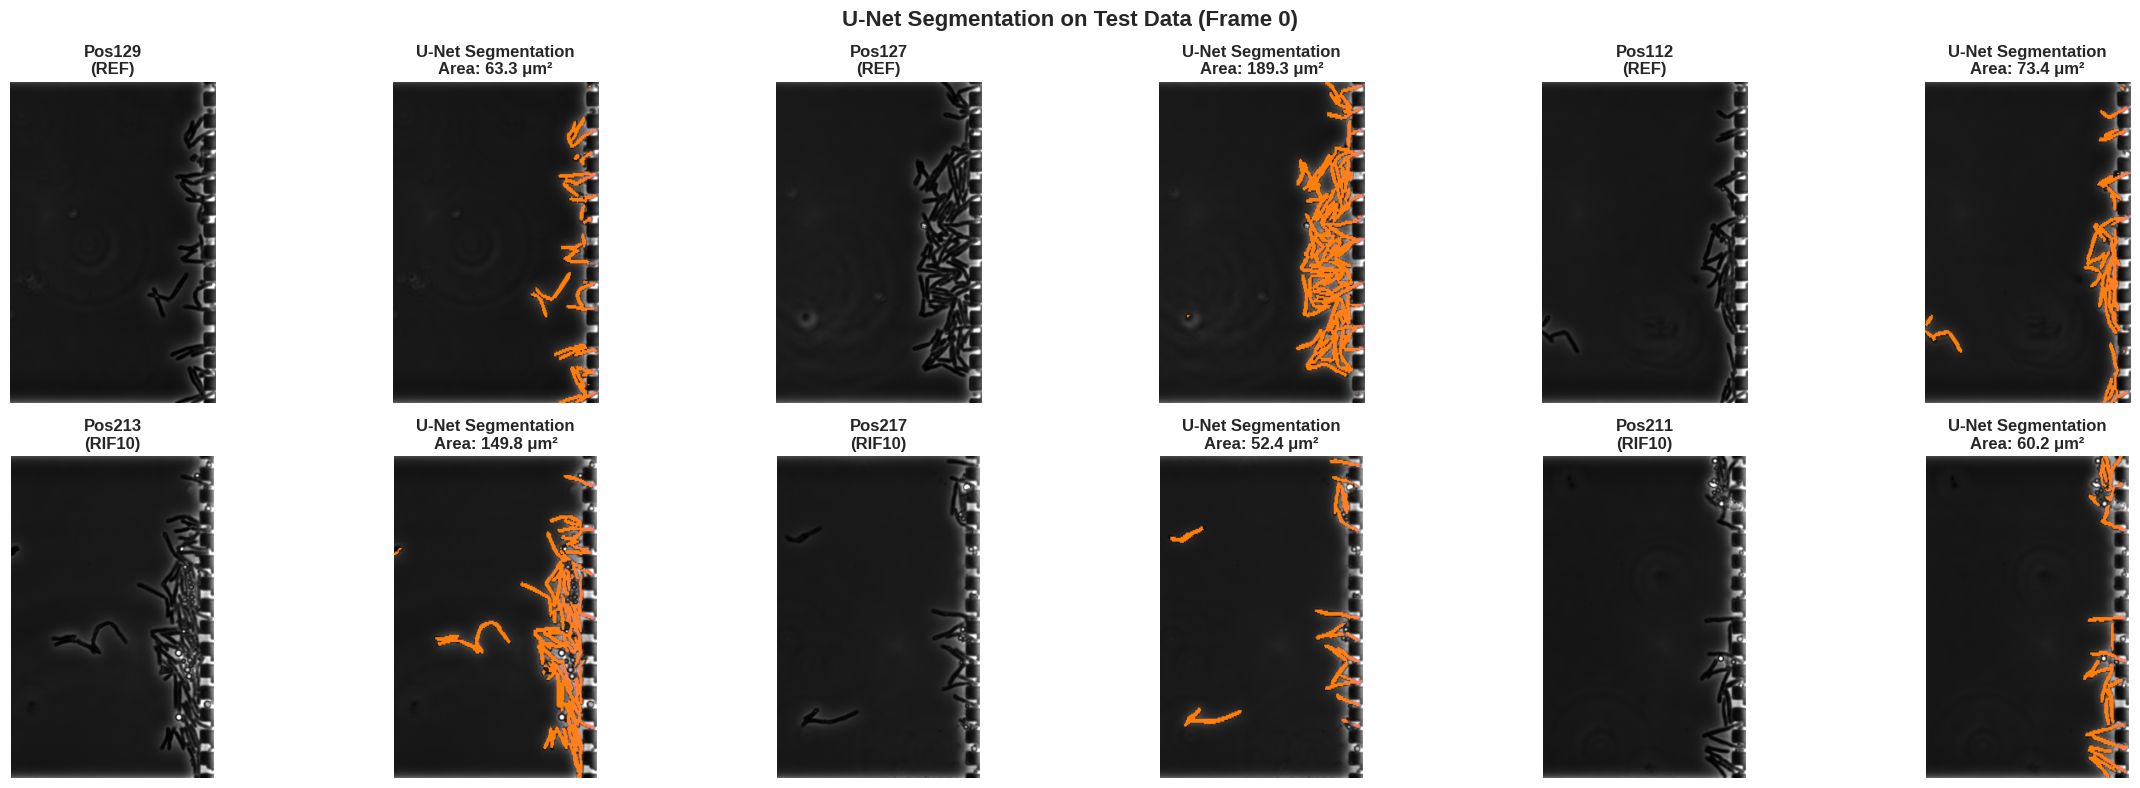


 Complete! U-Net segmentation applied to test data for classification.


In [ ]:
print("VISUALIZING U-NET PREDICTIONS")

# Pick 3 random REF and 3 random RIF10 samples
import random

fig, axes = plt.subplots(2, 6, figsize=(24, 8))

# REF samples (top row)
ref_positions = list(test_ref_areas.keys())
for i, pos_name in enumerate(random.sample(ref_positions, min(3, len(ref_positions)))):
    # Get first frame
    aphase_dir = TEST_REF_PHASE / pos_name / "aphase"
    img_path = sorted(list(aphase_dir.glob("img_*.tiff")))[0]

    # Load and segment
    img = np.array(Image.open(img_path))
    mask, area = segment_image_with_unet(img_path, model, device, image_size=IMAGE_SIZE, original_size=img.shape)

    # Original image
    axes[0, i*2].imshow(img, cmap='gray')
    axes[0, i*2].set_title(f'{pos_name}\n(REF)', fontweight='bold')
    axes[0, i*2].axis('off')

    # Overlay
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
    overlay = np.stack([img_norm, img_norm, img_norm], axis=-1)
    overlay[mask > 0, 0] = 1.0
    overlay[mask > 0, 1] = 0.5

    axes[0, i*2+1].imshow(overlay)
    axes[0, i*2+1].set_title(f'U-Net Segmentation\nArea: {area:.1f} μm²', fontweight='bold')
    axes[0, i*2+1].axis('off')

# RIF10 samples (bottom row)
rif_positions = list(test_rif10_areas.keys())
for i, pos_name in enumerate(random.sample(rif_positions, min(3, len(rif_positions)))):
    aphase_dir = TEST_RIF_PHASE / pos_name / "aphase"
    img_path = sorted(list(aphase_dir.glob("img_*.tiff")))[0]

    img = np.array(Image.open(img_path))
    mask, area = segment_image_with_unet(img_path, model, device, image_size=IMAGE_SIZE, original_size=img.shape)

    axes[1, i*2].imshow(img, cmap='gray')
    axes[1, i*2].set_title(f'{pos_name}\n(RIF10)', fontweight='bold')
    axes[1, i*2].axis('off')

    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
    overlay = np.stack([img_norm, img_norm, img_norm], axis=-1)
    overlay[mask > 0, 0] = 1.0
    overlay[mask > 0, 1] = 0.5

    axes[1, i*2+1].imshow(overlay)
    axes[1, i*2+1].set_title(f'U-Net Segmentation\nArea: {area:.1f} μm²', fontweight='bold')
    axes[1, i*2+1].axis('off')

plt.suptitle('U-Net Segmentation on Test Data (Frame 0)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n Complete! U-Net segmentation applied to test data for classification.")

VISUALIZING U-NET PREDICTIONS - MATCHED POSITIONS

 Found 7 matched position pairs
   Pairs: [(111, 211), (112, 212), (113, 213), (114, 214), (115, 215)]...

 Visualizing pairs: [(114, 214), (112, 212), (115, 215)]


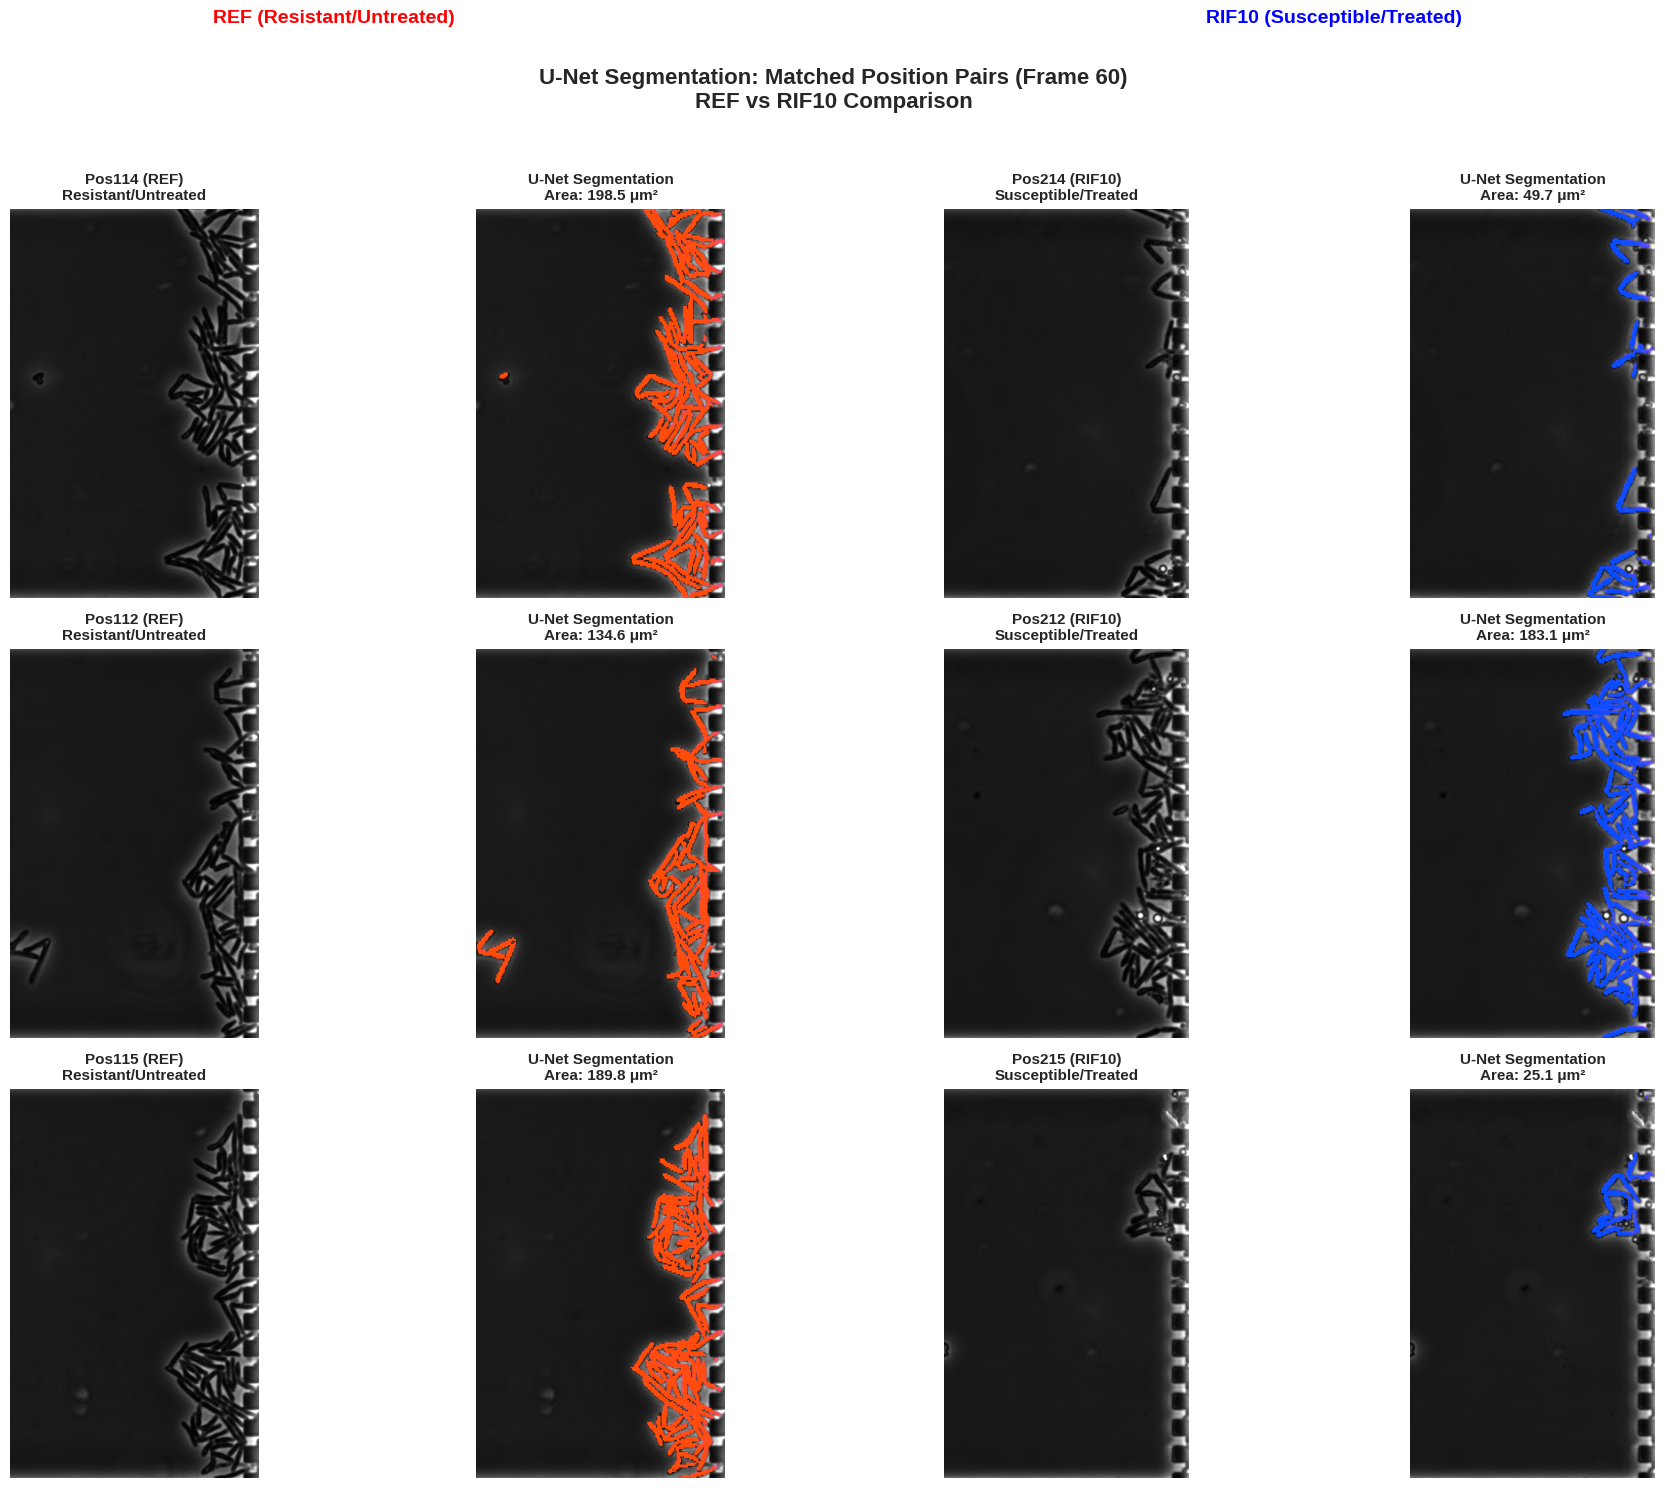

In [ ]:
print("="*70)
print("VISUALIZING U-NET PREDICTIONS - MATCHED POSITIONS")
print("="*70)

import random

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Get matched positions (REF 1XX and RIF10 2XX)
# Extract position numbers that exist in both datasets
ref_positions = list(test_ref_areas.keys())
rif_positions = list(test_rif10_areas.keys())

# Extract numbers from position names (e.g., "Pos117" → 117)
ref_numbers = sorted([int(pos.replace('Pos', '')) for pos in ref_positions if pos.startswith('Pos')])
rif_numbers = sorted([int(pos.replace('Pos', '')) for pos in rif_positions if pos.startswith('Pos')])

# Find matching pairs (e.g., 117 matches with 217)
matched_pairs = []
for ref_num in ref_numbers:
    # Convert REF 1XX to RIF 2XX (e.g., 117 → 217)
    rif_num = ref_num + 100
    if rif_num in rif_numbers:
        matched_pairs.append((ref_num, rif_num))

print(f"\n Found {len(matched_pairs)} matched position pairs")
print(f"   Pairs: {matched_pairs[:5]}..." if len(matched_pairs) > 5 else f"   Pairs: {matched_pairs}")

# Select 3 random pairs to visualize
if len(matched_pairs) >= 3:
    selected_pairs = random.sample(matched_pairs, 3)
else:
    selected_pairs = matched_pairs

print(f"\n Visualizing pairs: {selected_pairs}")

# Visualize each pair
for row, (ref_num, rif_num) in enumerate(selected_pairs):
    ref_pos_name = f"Pos{ref_num}"
    rif_pos_name = f"Pos{rif_num}"

    # === REF (left columns) ===
    try:
        aphase_dir = TEST_REF_PHASE / ref_pos_name / "aphase"
        img_path = sorted(list(aphase_dir.glob("img_*.tiff")))[60]

        # Load and segment
        img_ref = np.array(Image.open(img_path))
        mask_ref, area_ref = segment_image_with_unet(
            img_path, model, device,
            image_size=IMAGE_SIZE,
            original_size=img_ref.shape
        )

        # Original REF image
        axes[row, 0].imshow(img_ref, cmap='gray')
        axes[row, 0].set_title(f'{ref_pos_name} (REF)\nResistant/Untreated',
                               fontweight='bold', fontsize=11)
        axes[row, 0].axis('off')

        # REF segmentation overlay
        img_norm = (img_ref - img_ref.min()) / (img_ref.max() - img_ref.min() + 1e-8)
        overlay_ref = np.stack([img_norm, img_norm, img_norm], axis=-1)
        overlay_ref[mask_ref > 0, 0] = 1.0  # Red
        overlay_ref[mask_ref > 0, 1] = 0.3

        axes[row, 1].imshow(overlay_ref)
        axes[row, 1].set_title(f'U-Net Segmentation\nArea: {area_ref:.1f} μm²',
                               fontweight='bold', fontsize=11)
        axes[row, 1].axis('off')

    except Exception as e:
        print(f"     Could not load {ref_pos_name}: {e}")
        axes[row, 0].text(0.5, 0.5, f'Error loading\n{ref_pos_name}',
                         ha='center', va='center', fontsize=10)
        axes[row, 0].axis('off')
        axes[row, 1].axis('off')

    # === RIF10 (right columns) ===
    try:
        aphase_dir = TEST_RIF_PHASE / rif_pos_name / "aphase"
        img_path = sorted(list(aphase_dir.glob("img_*.tiff")))[60]

        # Load and segment
        img_rif = np.array(Image.open(img_path))
        mask_rif, area_rif = segment_image_with_unet(
            img_path, model, device,
            image_size=IMAGE_SIZE,
            original_size=img_rif.shape
        )

        # Original RIF10 image
        axes[row, 2].imshow(img_rif, cmap='gray')
        axes[row, 2].set_title(f'{rif_pos_name} (RIF10)\nSusceptible/Treated',
                               fontweight='bold', fontsize=11)
        axes[row, 2].axis('off')

        # RIF10 segmentation overlay
        img_norm = (img_rif - img_rif.min()) / (img_rif.max() - img_rif.min() + 1e-8)
        overlay_rif = np.stack([img_norm, img_norm, img_norm], axis=-1)
        overlay_rif[mask_rif > 0, 2] = 1.0  # Blue
        overlay_rif[mask_rif > 0, 1] = 0.3

        axes[row, 3].imshow(overlay_rif)
        axes[row, 3].set_title(f'U-Net Segmentation\nArea: {area_rif:.1f} μm²',
                               fontweight='bold', fontsize=11)
        axes[row, 3].axis('off')

    except Exception as e:
        print(f"     Could not load {rif_pos_name}: {e}")
        axes[row, 2].text(0.5, 0.5, f'Error loading\n{rif_pos_name}',
                         ha='center', va='center', fontsize=10)
        axes[row, 2].axis('off')
        axes[row, 3].axis('off')

# Add column labels at top
fig.text(0.25, 0.98, 'REF (Resistant/Untreated)', ha='center', fontsize=14, fontweight='bold', color='red')
fig.text(0.75, 0.98, 'RIF10 (Susceptible/Treated)', ha='center', fontsize=14, fontweight='bold', color='blue')

plt.suptitle('U-Net Segmentation: Matched Position Pairs (Frame 60)\nREF vs RIF10 Comparison',
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


VISUALIZING U-NET PREDICTIONS - MATCHED POSITIONS

 Found 7 matched position pairs
   Pairs: [(111, 211), (112, 212), (113, 213), (114, 214), (115, 215)]...

 Visualizing pairs: [(115, 215), (112, 212), (114, 214)]


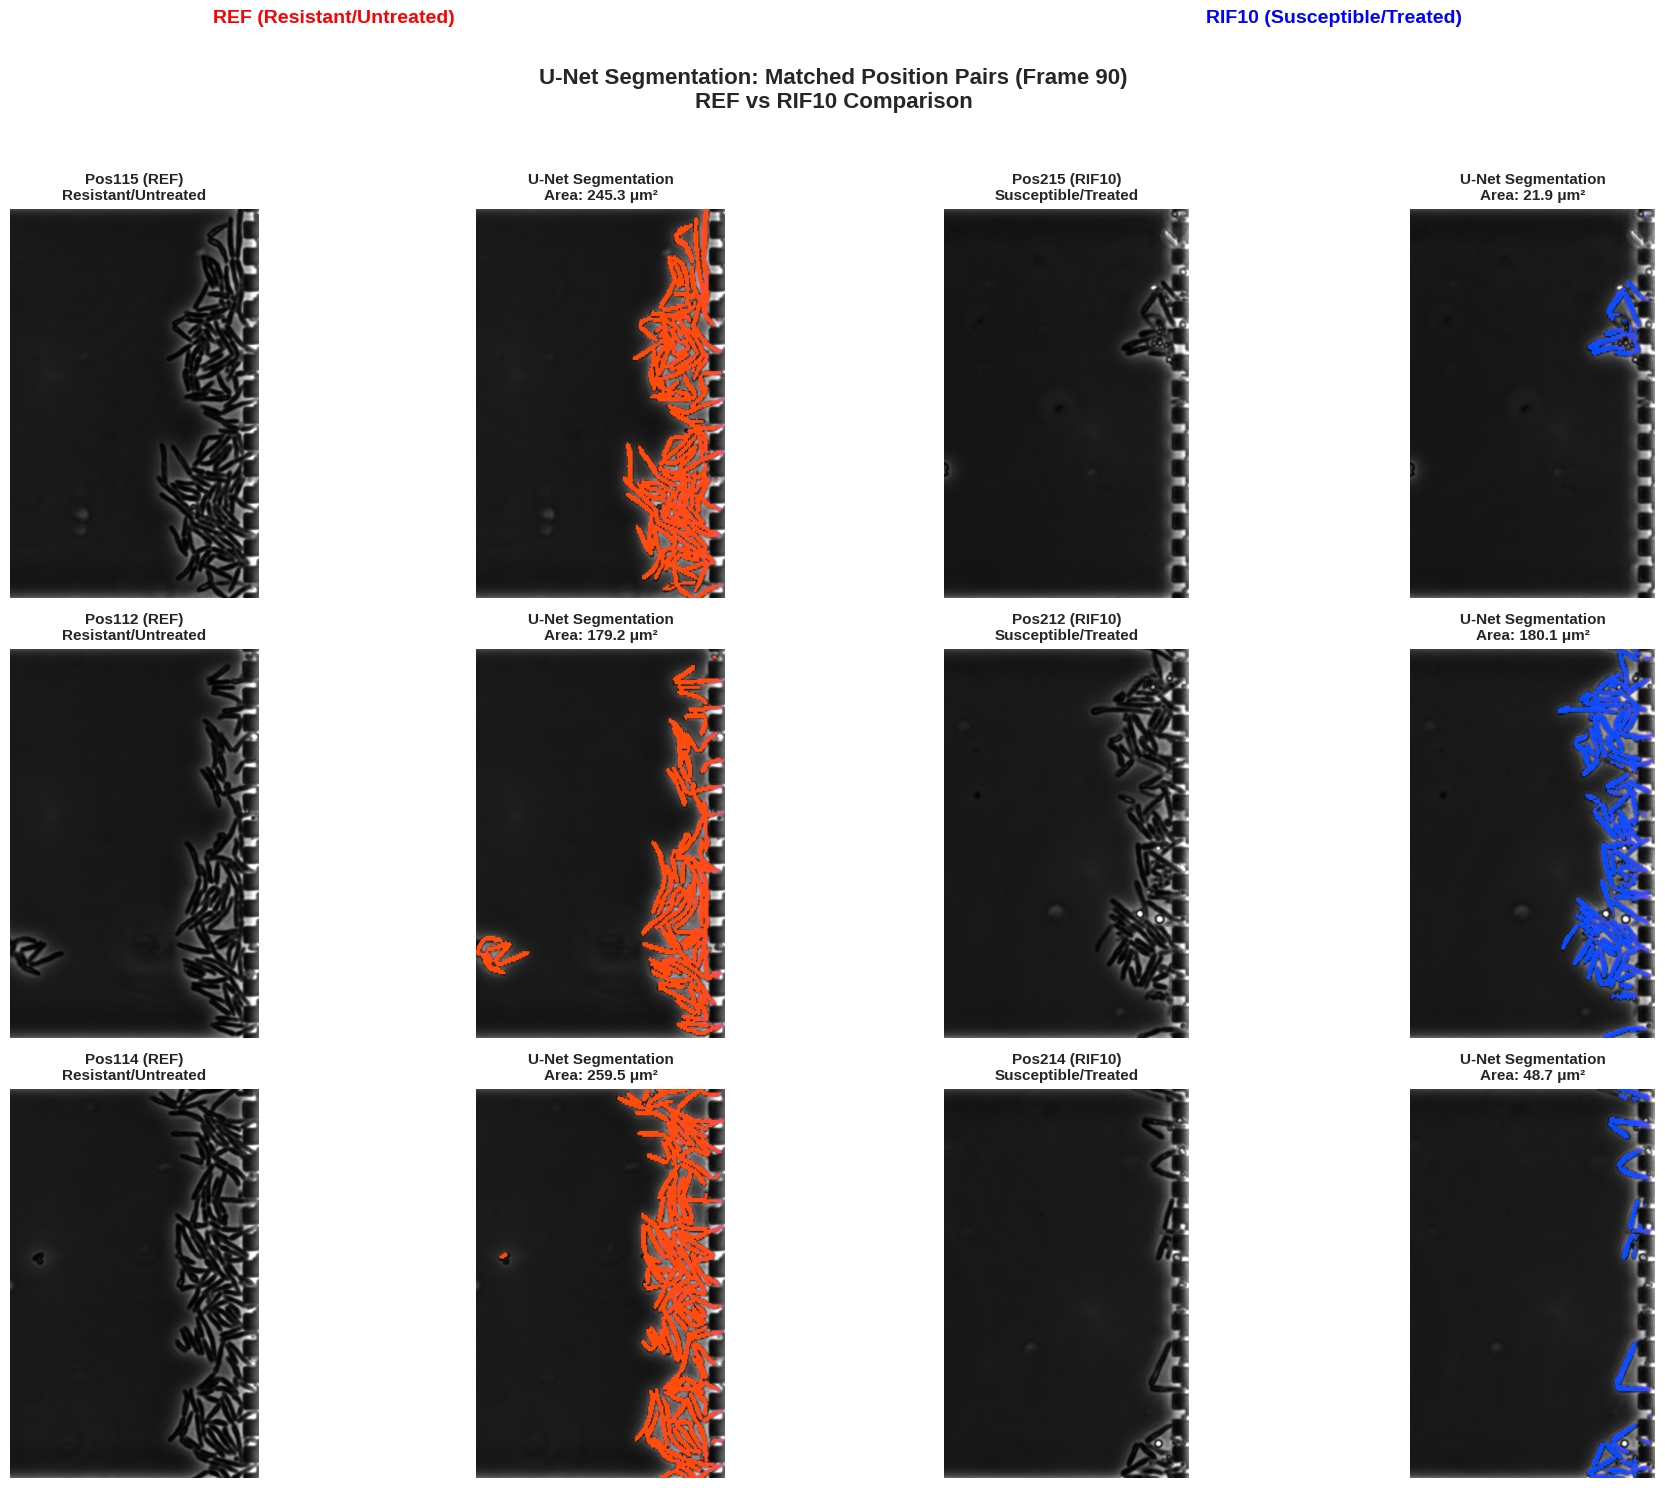

In [ ]:
print("VISUALIZING U-NET PREDICTIONS - MATCHED POSITIONS")

import random

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Get matched positions (REF 1XX and RIF10 2XX)
# Extract position numbers that exist in both datasets
ref_positions = list(test_ref_areas.keys())
rif_positions = list(test_rif10_areas.keys())

# Extract numbers from position names (e.g., "Pos117" → 117)
ref_numbers = sorted([int(pos.replace('Pos', '')) for pos in ref_positions if pos.startswith('Pos')])
rif_numbers = sorted([int(pos.replace('Pos', '')) for pos in rif_positions if pos.startswith('Pos')])

# Find matching pairs (e.g., 117 matches with 217)
matched_pairs = []
for ref_num in ref_numbers:
    # Convert REF 1XX to RIF 2XX (e.g., 117 → 217)
    rif_num = ref_num + 100
    if rif_num in rif_numbers:
        matched_pairs.append((ref_num, rif_num))

print(f"\n Found {len(matched_pairs)} matched position pairs")
print(f"   Pairs: {matched_pairs[:5]}..." if len(matched_pairs) > 5 else f"   Pairs: {matched_pairs}")

# Select 3 random pairs to visualize
if len(matched_pairs) >= 3:
    selected_pairs = random.sample(matched_pairs, 3)
else:
    selected_pairs = matched_pairs

print(f"\n Visualizing pairs: {selected_pairs}")

# Visualize each pair
for row, (ref_num, rif_num) in enumerate(selected_pairs):
    ref_pos_name = f"Pos{ref_num}"
    rif_pos_name = f"Pos{rif_num}"

    # === REF (left columns) ===
    try:
        aphase_dir = TEST_REF_PHASE / ref_pos_name / "aphase"
        img_path = sorted(list(aphase_dir.glob("img_*.tiff")))[90]

        # Load and segment
        img_ref = np.array(Image.open(img_path))
        mask_ref, area_ref = segment_image_with_unet(
            img_path, model, device,
            image_size=IMAGE_SIZE,
            original_size=img_ref.shape
        )

        # Original REF image
        axes[row, 0].imshow(img_ref, cmap='gray')
        axes[row, 0].set_title(f'{ref_pos_name} (REF)\nResistant/Untreated',
                               fontweight='bold', fontsize=11)
        axes[row, 0].axis('off')

        # REF segmentation overlay
        img_norm = (img_ref - img_ref.min()) / (img_ref.max() - img_ref.min() + 1e-8)
        overlay_ref = np.stack([img_norm, img_norm, img_norm], axis=-1)
        overlay_ref[mask_ref > 0, 0] = 1.0  # Red
        overlay_ref[mask_ref > 0, 1] = 0.3

        axes[row, 1].imshow(overlay_ref)
        axes[row, 1].set_title(f'U-Net Segmentation\nArea: {area_ref:.1f} μm²',
                               fontweight='bold', fontsize=11)
        axes[row, 1].axis('off')

    except Exception as e:
        print(f"     Could not load {ref_pos_name}: {e}")
        axes[row, 0].text(0.5, 0.5, f'Error loading\n{ref_pos_name}',
                         ha='center', va='center', fontsize=10)
        axes[row, 0].axis('off')
        axes[row, 1].axis('off')

    # === RIF10 (right columns) ===
    try:
        aphase_dir = TEST_RIF_PHASE / rif_pos_name / "aphase"
        img_path = sorted(list(aphase_dir.glob("img_*.tiff")))[90]

        # Load and segment
        img_rif = np.array(Image.open(img_path))
        mask_rif, area_rif = segment_image_with_unet(
            img_path, model, device,
            image_size=IMAGE_SIZE,
            original_size=img_rif.shape
        )

        # Original RIF10 image
        axes[row, 2].imshow(img_rif, cmap='gray')
        axes[row, 2].set_title(f'{rif_pos_name} (RIF10)\nSusceptible/Treated',
                               fontweight='bold', fontsize=11)
        axes[row, 2].axis('off')

        # RIF10 segmentation overlay
        img_norm = (img_rif - img_rif.min()) / (img_rif.max() - img_rif.min() + 1e-8)
        overlay_rif = np.stack([img_norm, img_norm, img_norm], axis=-1)
        overlay_rif[mask_rif > 0, 2] = 1.0  # Blue
        overlay_rif[mask_rif > 0, 1] = 0.3

        axes[row, 3].imshow(overlay_rif)
        axes[row, 3].set_title(f'U-Net Segmentation\nArea: {area_rif:.1f} μm²',
                               fontweight='bold', fontsize=11)
        axes[row, 3].axis('off')

    except Exception as e:
        print(f"     Could not load {rif_pos_name}: {e}")
        axes[row, 2].text(0.5, 0.5, f'Error loading\n{rif_pos_name}',
                         ha='center', va='center', fontsize=10)
        axes[row, 2].axis('off')
        axes[row, 3].axis('off')

# Add column labels at top
fig.text(0.25, 0.98, 'REF (Resistant/Untreated)', ha='center', fontsize=14, fontweight='bold', color='red')
fig.text(0.75, 0.98, 'RIF10 (Susceptible/Treated)', ha='center', fontsize=14, fontweight='bold', color='blue')

plt.suptitle('U-Net Segmentation: Matched Position Pairs (Frame 90)\nREF vs RIF10 Comparison',
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
